# DAT535 Project
---

## Magnus Egelland & Ning Bao Truong

This notebook serves as the main file for the DAT535 project. It processes data from `anime-dataset-2023.csv`, which contains comprehensive information about anime from MyAnimeList (MAL).

The notebook extracts and filters the data, preparing it for training a simple linear regression model. The model predicts anime scores based on features such as genre and studio, among others. Given the dataset size of approximately 15 MB, it was also used light-load benchmark for processing and analysis, while calulating average animme score from user score is the heavy load bemchmark(`average_anime_score.ipynb`).


### Light Load Benchmark: Anime Dataset Cleaning and Score prediction

This notebook focuses on performing a light load benchmark to evaluate the efficiency of PySpark in handling smaller datasets with moderate computational requirements. The primary goal is to clean, preprocess, and analyze an anime dataset to extract meaningful insights and prepare it for machine learning workflows.

The workflow is divided into two key stages:

1. **Data Cleaning and Preprocessing**:
   - The raw anime dataset is cleaned to handle multiline records, escape special characters, and normalize field counts.
   - Selected columns are extracted, and the dataset is saved in a structured format for further analysis.

2. **Feature Engineering**:
   - The cleaned dataset is processed to compute average scores for genres and studios, transforming string-based fields into numerical representations.
   - These features are structured into labeled datasets, making them suitable for predictive modeling.






In [8]:
%reset # reset all stored variables

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  stored, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


### Data Cleaning and Preprocessing Section

This section focuses on cleaning and preprocessing a raw anime dataset for further analysis. The key steps performed are as follows:

1. **Spark Session Configuration**: 
   A Spark session is initialized with specific configurations for memory, cores, and instances to handle distributed data processing efficiently.

2. **Data Loading**: 
   The dataset is loaded as an RDD (Resilient Distributed Dataset) from a CSV file. The header row is identified and excluded from the main dataset.

3. **Multiline Record Cleaning**: 
   Multiline records in the dataset are identified and combined into single records using a cleaning function. This ensures that each record corresponds to a single line, preventing parsing issues.

4. **Quote Handling and Parsing**: 
   A custom function is used to handle embedded quotes and escape characters within fields. This ensures proper parsing of the dataset while maintaining the integrity of quoted fields.

5. **Field Normalization**: 
   Each record is normalized to ensure it contains exactly 24 fields:
   - Missing fields are padded with `None`.
   - Excess fields are consolidated into the last field.

6. **RDD to DataFrame Conversion**: 
   The cleaned and parsed RDD is converted into a Spark DataFrame, using the original header as column names.

7. **DataFrame Preview and Storage**: 
   The resulting DataFrame is previewed to verify the cleaning process and saved as a cleaned CSV file for downstream tasks. The file is written with headers, and internal quotes are properly escaped.



In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import csv
from io import StringIO
import re

from pyspark.sql import SparkSession
from io import StringIO
import csv
# Create a Spark session

# Variables for Spark configuration
spark_master = "yarn"
driver_memory = "2048m"
am_memory = "1024m"
executor_memory = "1g"
executor_cores = "4"
executor_instances = "3"
max_cores = "12"

# Create a Spark session with the configurations
spark = SparkSession.builder \
    .appName("Benchmark light load 3 config 5") \
    .master(spark_master) \
    .config("spark.driver.memory", driver_memory) \
    .config("spark.yarn.am.memory", am_memory) \
    .config("spark.executor.memory", executor_memory) \
    .config("spark.executor.cores", executor_cores) \
    .config("spark.executor.instances", executor_instances) \
    .config("spark.cores.max", max_cores) \
    .getOrCreate()


# Define the file path
filepath = "project/anime-dataset-2023_copy.csv"

# Read the CSV file as an RDD of strings
rdd = spark.sparkContext.textFile(filepath)

# Extract the header
header = rdd.first()
data_rdd = rdd.filter(lambda line: line != header)  # Filter out the header row

# Function to clean and parse multiline records
def clean_and_parse(lines):
    cleaned_lines = []
    current_line = ""

    for line in lines:
        # Check if the line starts with a digit (indicating a new record)
        if re.match(r'^\d+,.+', line):
            # If there's a current line, save it to the list before starting a new record
            if current_line:
                cleaned_lines.append(current_line)
            current_line = line  # Start a new record
        else:
            # This line is a continuation of the previous record
            current_line += " " + line.strip()  # Merge with a space

    # Add the last processed line
    if current_line:
        cleaned_lines.append(current_line)

    return cleaned_lines

# Clean and parse the RDD lines
cleaned_rdd = data_rdd.mapPartitions(clean_and_parse)

# Function to parse and fix escaping of quotes within fields
def parse_and_escape_quotes(line):
    # Use csv.reader to correctly parse fields with embedded quotes
    reader = csv.reader(StringIO(line), quotechar='"', skipinitialspace=True)
    fields = next(reader)

    # Escape internal quotes by doubling them for fields that contain quotes
    #fields = [field.replace('"', '""') if '"' in field else field for field in fields]

    # Ensure the row has exactly 24 fields
    if len(fields) < 24:
        # Pad the missing fields with None
        fields.extend([None] * (24 - len(fields)))
    elif len(fields) > 24:
        # Combine extra fields into the last field
        fields = fields[:23] + [",".join(fields[23:])]

    return Row(*fields)

# Parse each cleaned line into a Row object with properly escaped quotes
parsed_rdd = cleaned_rdd.map(parse_and_escape_quotes)

# Create DataFrame from parsed RDD
columns = header.split(",")  # Split the header to get column names
anime_df = spark.createDataFrame(parsed_rdd, schema=columns)

# Show the resulting DataFrame
anime_df.show(30, truncate=False)

# Define the output path
output_path = "project/anime_dataset_cleaned.csv"

# Save the cleaned DataFrame as a CSV file
anime_df.write.csv(output_path, header=True, mode='overwrite', escape='"')




+--------+--------------------------------------------------------------------+----------------------------------------------+--------------------------------------------------+-----+-----------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Processing and Filtering Dataset Section

This section focuses on processing a cleaned anime dataset, filtering out invalid records, and restructuring it for further analysis. The key steps performed are as follows:

1. **Data Loading**:
   The cleaned dataset is loaded as an RDD (Resilient Distributed Dataset) from a CSV file. The header row is identified and excluded from the main data for processing.

2. **Line Processing**:
   Each line in the dataset is processed to:
   - Remove null characters to prevent parsing errors.
   - Parse the fields using a CSV reader to handle embedded quotes and other formatting issues.
   - Log problematic lines for debugging while ensuring data consistency.

3. **Filtering Invalid Rows**:
   Rows with specific fields marked as "UNKNOWN" are filtered out. This ensures that only valid records with meaningful data are retained for downstream analysis.

4. **Field Selection and Transformation**:
   Selected fields from each record are extracted and transformed:
   - Commas in text fields like `name`, `genre`, and `studios` are replaced with semicolons to avoid issues during CSV serialization.
   - Key features such as `anime_id`, `score`, `rank`, and `popularity` are preserved for further analysis.

5. **Verification**:
   A sample of 10 processed rows is taken and printed to validate the correctness of the processing steps. This provides a quick check to ensure the transformations are applied as intended.

6. **DataFrame Creation**:
   The processed RDD is converted into a Spark DataFrame with a predefined schema, making the data structured and suitable for analysis or storage.

7. **Saving the Processed Dataset**:
   The resulting DataFrame is saved as a new CSV file. The file includes headers, and any internal quotes in the fields are properly escaped. The overwrite mode ensures that any existing file at the output path is replaced with the new dataset.



In [10]:


# Define the file path
filepath = "project/anime_dataset_cleaned.csv"

# Read the CSV file as an RDD of strings
rdd = spark.sparkContext.textFile(filepath)

# Extract the header
header = rdd.first()

def process_line(line):
    try:
        # Remove null characters
        line = line.replace('\x00', '')
        # Use csv.reader to correctly parse the quoted fields
        reader = csv.reader(StringIO(line), quotechar='"', skipinitialspace=True)
        fields = next(reader)

        #fields = [field.replace(r'\"', '"') for field in fields]
        return fields
    except Exception as e:
        # Print or log the problematic line for debugging
        print(f"Error processing line: {line} | Error: {e}")
        return None
    


# Filter out the header and process the lines
processed_rdd = rdd.filter(lambda line: line != header) \
    .map(process_line) \
    .filter(lambda row: row[4] != "UNKNOWN" and row[18] != "UNKNOWN" and row[19] != "UNKNOWN" and row[5] != "UNKNOWN" and row[14] != "UNKNOWN" ) \
    .map(lambda row: (
        row[0],                     # anime_id
        row[1].replace(',', ';'),   # name
        row[4],                     # score
        row[5].replace(',', ';'),   # genre 
        row[7],                     # type
        row[8],                     # episodes
        row[14].replace(',', ';'),  # studios
        row[18],                    # rank
        row[19],                    # popularity
        row[20],                    # favorites
        row[21],                    # scored_by
        row[22]                     # members
    ))

# Take a sample of processed rows to verify correctness
first_10_lines = processed_rdd.take(10)
for line in first_10_lines:
    print(line)

# Define schema for the selected columns
schema = ["anime_id", "name", "score", "genre", "type", "episodes", "studios", "rank", "popularity", "favorites", "scored_by", "members"]

# Create a DataFrame from the processed RDD
anime_df = spark.createDataFrame(processed_rdd, schema=schema)

# Show the resulting DataFrame
anime_df.show(truncate=False)

# Define the output path
output_path = "project/anime_dataset_trimmed.csv"

# Save the DataFrame as a CSV file with overwrite mode
anime_df.write.csv(output_path, header=True, mode='overwrite', escape='')




('1', 'Cowboy Bebop', '8.75', 'Action; Award Winning; Sci-Fi', 'TV', '26.0', 'Sunrise', '41.0', '43', '78525', '914193.0', '1771505')
('5', 'Cowboy Bebop: Tengoku no Tobira', '8.38', 'Action; Sci-Fi', 'Movie', '1.0', 'Bones', '189.0', '602', '1448', '206248.0', '360978')
('6', 'Trigun', '8.22', 'Action; Adventure; Sci-Fi', 'TV', '26.0', 'Madhouse', '328.0', '246', '15035', '356739.0', '727252')
('7', 'Witch Hunter Robin', '7.25', 'Action; Drama; Mystery; Supernatural', 'TV', '26.0', 'Sunrise', '2764.0', '1795', '613', '42829.0', '111931')
('8', 'Bouken Ou Beet', '6.94', 'Adventure; Fantasy; Supernatural', 'TV', '52.0', 'Toei Animation', '4240.0', '5126', '14', '6413.0', '15001')
('15', 'Eyeshield 21', '7.92', 'Sports', 'TV', '145.0', 'Gallop', '688.0', '1252', '1997', '86524.0', '177688')
('16', 'Hachimitsu to Clover', '8.0', 'Comedy; Drama; Romance', 'TV', '24.0', 'J.C.Staff', '589.0', '862', '4136', '81747.0', '260166')
('17', 'Hungry Heart: Wild Striker', '7.55', 'Comedy; Slice of L

### Feature Engineering for Genres and Studios

This section focuses on transforming the trimmed anime dataset into a format suitable for machine learning by engineering features based on genres, studios, and other relevant attributes. Below is a summary of the steps:

1. **Data Loading**:
   The trimmed dataset is loaded as an RDD, and the header row is identified and excluded. This ensures that only valid data records are processed.

2. **Computing Average Scores for Genres and Studios**:
   - Genres and studios are extracted from each record as key-value pairs, where the key is the name of the genre or studio, and the value is a tuple of the anime's score and a count of 1.
   - These pairs are aggregated to calculate the total score and occurrence count for each genre and studio.
   - The average score is then computed by dividing the total score by the count. The results are stored in a dictionary for efficient lookup during feature engineering.

3. **Feature Transformation**:
   - Each line in the dataset is processed to extract relevant fields such as `rank`, `popularity`, `favorites`, and `members`.
   - Rank and popularity are transformed into scaled features using predefined maximum values.
   - Average scores for genres and studios are retrieved from the dictionary and combined if multiple genres or studios are associated with an anime.

4. **Creating Labeled Features**:
   - A labeled feature vector is created for each anime record, containing transformed features and a label (the anime's score).
   - This ensures the data is structured for use in machine learning models.

5. **Verification**:
   - A sample of 10 processed rows is printed to validate that the feature engineering process is functioning as intended.

6. **DataFrame Creation**:
   - The processed RDD is converted into a Spark DataFrame, where each row contains a dense vector of features and the corresponding label.
   - This structured format is ideal for training machine learning models in PySpark or exporting for use in other frameworks.



In [11]:
from pyspark.sql import SparkSession
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from io import StringIO
import csv



# Load CSV file as RDD
filepath = "project/anime_dataset_trimmed.csv"
rdd = spark.sparkContext.textFile(filepath)

# Extract the header
header = rdd.first()

# Remove the header
data_rdd = rdd.filter(lambda line: line != header)

# Define the maximum values for rank and popularity
MAX_RANK = 12701.0
MAX_POPULARITY = 19191.0

# Function to extract key-value pairs of genres and studios with their scores
def extract_studio_and_genre_scores(line):
    line = line.replace('\x00', '')  # Clean null bytes
    reader = csv.reader(StringIO(line), quotechar='"', skipinitialspace=True)
    fields = next(reader)

    score = float(fields[2])  # Anime score
    studios = fields[6].split(";")  # Studios field
    genres = fields[3].split(";")  # Genres field

    # Create key-value pairs for both studios and genres
    return [(studio.strip(), (score, 1)) for studio in studios] + [(genre.strip(), (score, 1)) for genre in genres]


# 1. Extract key-value pairs of genres and studios with scores using flatMap
# 2. Aggregate scores and counts for each key (studio/genre) using reduceByKey
# 3. Calculate the average score for each studio and genre using mapValues
# 4. Collect the results into a dictionary for efficient lookup
avg_scores = data_rdd.flatMap(extract_studio_and_genre_scores) \
    .reduceByKey(lambda acc, value: (acc[0] + value[0], acc[1] + value[1])) \
    .mapValues(lambda total_and_count: total_and_count[0] / total_and_count[1]) \
    .collectAsMap()


# Sample output for verification
for key, value in list(avg_scores.items())[:10]:
    print(f"{key}: {value}")

# Function to parse and clean the CSV line, then compute features
def parse_line(line, avg_scores):
    line = line.replace('\x00', '')  # Remove null bytes
    reader = csv.reader(StringIO(line), quotechar='"', skipinitialspace=True)
    fields = next(reader)
        
    # Extract relevant fields
    anime_id = fields[0]
    rank = float(fields[7])
    popularity = float(fields[8])
    favorites = float(fields[9])
    scoredby = float(fields[10])
    members = float(fields[11])

    # Transform rank and popularity
    transform_rank = MAX_RANK - rank + 1
    transform_popularity = MAX_POPULARITY - popularity + 1

    # Compute average scores for studios and genres
    studios = fields[6].split(";")
    genres = fields[3].split(";")
    studio_avg_score = sum(avg_scores.get(studio.strip(), 0) for studio in studios) / len(studios)
    genre_avg_score = sum(avg_scores.get(genre.strip(), 0) for genre in genres) / len(genres)

    # Label and features
    label = float(fields[2])  # Anime score
    features = [
        transform_rank,
        transform_popularity,
        favorites,
        scoredby,
        members,
        studio_avg_score,
        genre_avg_score,
    ]

    return LabeledPoint(label, features)

# Parse dataset and apply transformations
parsed_rdd = data_rdd.map(lambda line: parse_line(line, avg_scores)).filter(lambda row: row is not None)

# Sample parsed rows for verification
for line in parsed_rdd.take(10):
    print(line)

# Create a DataFrame with labeled features
labeled_df = spark.createDataFrame(parsed_rdd.map(lambda lp: Row(features=Vectors.dense(lp.features), label=lp.label)))






Sunrise: 6.861124999999998
Action: 6.781743041889233
Sci-Fi: 6.660584741891284
Bones: 7.342695035460994
Madhouse: 6.9352161383285305
Adventure: 6.784546225614929
Mystery: 7.071040462427746
Gallop: 6.803030303030302
Comedy: 6.681156794425092
Slice of Life: 6.679318423855165
(8.75,[12661.0,19149.0,78525.0,914193.0,1771505.0,6.861124999999998,7.038392206996606])
(8.38,[12513.0,18590.0,1448.0,206248.0,360978.0,7.342695035460994,6.721163891890258])
(8.22,[12374.0,18946.0,15035.0,356739.0,727252.0,6.9352161383285305,6.742291336465148])
(7.25,[9938.0,17397.0,613.0,42829.0,111931.0,6.861124999999998,6.932203925308886])
(6.94,[8462.0,14066.0,14.0,6413.0,15001.0,6.635108538350213,6.812905215126091])
(7.92,[12014.0,17940.0,1997.0,86524.0,177688.0,6.803030303030302,6.8783569979716])
(8.0,[12113.0,18330.0,4136.0,81747.0,260166.0,6.818719346049047,6.856257810503699])
(7.55,[11151.0,14980.0,237.0,12960.0,24172.0,6.765174418604652,6.746277405417286])
(8.16,[12309.0,17919.0,1237.0,97878.0,173710.0,6.64

In [12]:


# Debugging: print the average scores for studios and genres
print("Average scores for studios and genres:")
for key, avg_score in avg_scores.items():
    print(f"{key}: {avg_score}")

Average scores for studios and genres:
Sunrise: 6.861124999999998
Action: 6.781743041889233
Sci-Fi: 6.660584741891284
Bones: 7.342695035460994
Madhouse: 6.9352161383285305
Adventure: 6.784546225614929
Mystery: 7.071040462427746
Gallop: 6.803030303030302
Comedy: 6.681156794425092
Slice of Life: 6.679318423855165
Suspense: 7.197654320987656
Pierrot: 6.815918367346938
Trans Arts: 6.621176470588235
Studio Comet: 6.930212765957446
Studio Deen: 6.9406810035842295
OLM: 6.618907563025209
Tokyo Movie Shinsha: 6.901076923076925
Bee Train: 6.80548387096774
Zexcs: 6.526029411764705
Daume: 6.692413793103449
Group TAC: 6.551294117647061
Trinet Entertainment: 6.261111111111111
Telecom Animation Film: 7.043421052631579
Studio Flag: 6.48
Ashi Productions: 6.340967741935485
Satelight: 6.9038613861386136
Manglobe: 7.090000000000001
Garyuu Studio: 5.54
Arms: 6.299032258064518
Venet: 5.866666666666667
Studio Ranmaru: 5.7925
Rikuentai: 6.022
Minami Machi Bugyousho: 5.8660000000000005
Plum: 6.00625
Karaku: 7

### Linear Regression Model Training and Evaluation

This section focuses on training a linear regression model using the processed dataset, evaluating its predictions, and visualizing the results. Below are the key steps:

1. **Train-Test Split**:
   The dataset is randomly split into training and testing sets, with 80% of the data used for training the model and 20% reserved for evaluation. This ensures the model is trained and tested on separate subsets of the data.

2. **Model Training**:
   A linear regression model is initialized with a regularization parameter (`regParam`) to control overfitting. The model is then trained on the training data, learning the relationship between the features and the label (anime scores).

3. **Making Predictions**:
   The trained model is used to make predictions on the test data. The resulting predictions include both the actual labels and the predicted values, allowing for evaluation of the model's performance.

4. **Data Collection for Visualization**:
   The predicted and actual values are collected from the test data and split into two lists for visualization purposes. This step prepares the data for plotting.

5. **Scatter Plot of Predictions**:
   A scatter plot is created to visualize the relationship between the actual and predicted values:
   - Each point represents a pair of actual and predicted scores.
   - A reference line is added to indicate perfect prediction, providing a visual benchmark for model accuracy.

6. **Plot Customization**:
   The plot is enhanced with titles, axis labels, a legend, and a grid to make it informative and easy to interpret.

7. **Stopping the Spark Session**:
   The Spark session is stopped to release resources after completing the processing and analysis.



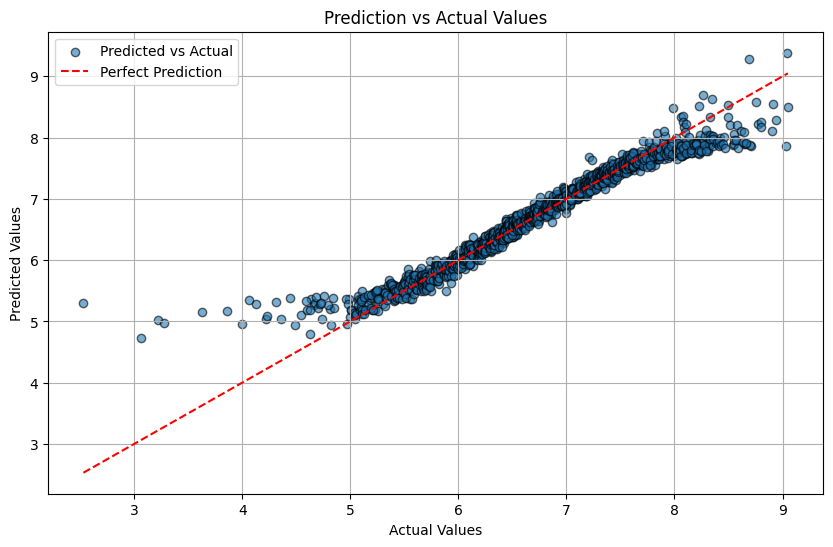

In [13]:
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

train_data, test_data = labeled_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="label", regParam=0.1)
model = lr.fit(train_data)

predictions = model.transform(test_data)

# If you want to print them out manually:
# for row in predictions.select("prediction", "label").collect():
#     print(f"Predicted: {row['prediction']:.2f}, Actual: {row['label']:.2f}")

predicted_actual = predictions.select("prediction", "label").collect()

# Split the collected data into two lists for plotting
actual = [row["label"] for row in predicted_actual]
predicted = [row["prediction"] for row in predicted_actual]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, alpha=0.6, edgecolor='k', label='Predicted vs Actual')

# Add a reference line for perfect prediction
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')

# Customize the plot
plt.title("Prediction vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

spark.stop()